In [16]:
import pandas as pd
import xgboost as xgb
import sklearn as sk
import warnings
warnings.filterwarnings("ignore")
from AUTO_ML import data_cleaning, feature_check, autoML, autoPredict

In [3]:
data = pd.read_csv('./Test_Data/Titanic_train.csv')

#### Step One: Clean the dataset

In [4]:
actions_dict = {1: 'drop', 2: 'dummy', 3: 'indicator', 4: 'numeric', 5: 'time', 6: 'later'} # user defined
tar_col = 'Survived'
# set up the cleaning object
s1 = data_cleaning(data, list(set(data.columns)-set([tar_col])), tar_col, actions_dict)
# use start_action function to loop through all the features
action_dict = s1.start_action() 
action_dict

{'Age': '4',
 'Embarked': '2',
 'Fare': '4',
 'Parch': '2',
 'Pclass': '2',
 'Sex': '2',
 'SibSp': '2'}

In [5]:
# action_dict records all the necessary action, now we can clean all of them at once
drop = [i for i in action_dict.keys() if action_dict[i]==str(1)]
dummy = [i for i in action_dict.keys() if action_dict[i]==str(2)]
indicator = [i for i in action_dict.keys() if action_dict[i]==str(3)]
numeric = [i for i in action_dict.keys() if action_dict[i]==str(4)]
time = [i for i in action_dict.keys() if action_dict[i]==str(5)]
later = [i for i in action_dict.keys() if action_dict[i]==str(6)]

data = data.drop(drop,axis=1)
data[numeric] = data[numeric].astype(float)
for ind in indicator:
    data[ind] = np.where(~data[ind].isnull(),1,0)
data = pd.get_dummies(data,columns=dummy,dummy_na=True)
nan_col = []
for i in data.columns:
    if 'nan' in i:
        nan_col.append(i)
data = data.drop(drop+nan_col,axis=1)

#### Step Two: Check data cleaning result

In [8]:
# use check_missing function to check which features have N/A
# returns (dataframe, column name list)
s2 = feature_check(data, 'Survived') # set up checking object
s2.check_missing()[0].head()

,features,#null
0,Survived,0
1,Age,177
2,Fare,0
3,Embarked_C,0
4,Embarked_Q,0


In [9]:
s2.check_missing()[1] # only age column has missing values

['Age']

In [10]:
s2.check_object()  # check whether there are still object type, True means no object type

True

In [11]:
s2.check_imblance() # check class-balance, we should use smote

0    549
1    342
Name: Survived, dtype: int64

#### Step Three: AUTO ML

In [12]:
s3 = autoML(data, 'Survived') # set up auto ML object
s3.split() # split the dataset into train and test
# can use s3.train to check train set
# s3.test to check test set, you can also define your own

In [13]:
# grid-search on k-fold to find the best hyper-parameters

grid_serach = {'max_depth': [1, 3, 5, 7, 9],
 'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
 'n_estimators': [10, 30, 50 ,100]} # the grid_search range

# you can define your own filler such as {'Age': 30}
fill_method = 'mean' # how you want to fill the missing values

# return (grid_search_dictionary, the highest score, the lowest score)
result = s3.cross_validation(fold=5, 
                             col = list(set(data.columns)-set(['Survived'])), 
                            model = xgb.XGBClassifier, 
                            params=grid_serach, 
                            scorer=sk.metrics.roc_auc_score, # we use roc for classification
                            fill_method = fill_method, 
                            fkbest=[5,6,7,8,9,10,11,12,13,14],  # feature selection using f-statistics 
                            scaling = True, 
                            smote=True, 
                            classification=True)

In [20]:
dict(list(result[0].items())[0:10]) # list ten of the result

{(1, 0.1, 10, 5): 0.8257385911445162,
 (1, 0.1, 30, 5): 0.824335293884807,
 (1, 0.1, 50, 5): 0.8275181120389448,
 (1, 0.1, 100, 5): 0.8271984975802338,
 (1, 0.3, 10, 5): 0.8269705667161146,
 (1, 0.3, 30, 5): 0.8252491276738887,
 (1, 0.3, 50, 5): 0.8273198701732714,
 (1, 0.3, 100, 5): 0.8287610324781036,
 (1, 0.5, 10, 5): 0.8153059146843533,
 (1, 0.5, 30, 5): 0.8264431996051664}

In [21]:
result[1] # the best parameters

((9, 0.5, 100, 9), 0.8642311650180499)

In [22]:
result[2]

((3, 0.1, 10, 8), 0.7923000945122849)

The score is 0.8789083200847907


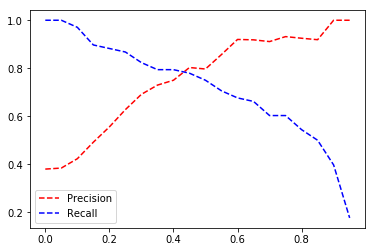

In [23]:
# retrain on the whole trainset and test on the testset
# automatically plot the precision and recall line
# return (model, prediction)
best_params = {'max_depth': [9],
 'colsample_bytree': [0.5],
 'n_estimators': [100]}
fill_method = 'mean'

result = s3.predict_test(col = list(set(data.columns)-set(['Survived'])), 
                        model = xgb.XGBClassifier, 
                        best_params=best_params, 
                        scorer=sk.metrics.roc_auc_score,
                        fill_method = fill_method, fkbest=9, 
                        scaling = True, smote=True, classification=True)

In [24]:
result[0]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

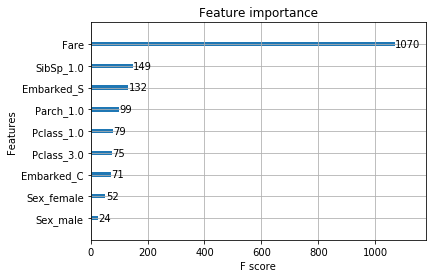

In [25]:
xgb.plot_importance(result[0],max_num_features=10)

In [30]:
result[1][0:20] # preview the top 20 of the prediction

array([0.0856477 , 0.28298745, 0.9668463 , 0.19244507, 0.4023283 ,
       0.05608154, 0.40110946, 0.8002341 , 0.99014986, 0.08776058,
       0.23808497, 0.96584445, 0.94833195, 0.3285637 , 0.37543702,
       0.32664812, 0.39660555, 0.053753  , 0.2818655 , 0.06296539],
      dtype=float32)

In [31]:
# retrain on the whole dataset and wait for the real-test set in practice
s3.final_product(col = list(set(data.columns)-set(['Survived'])), 
                 model = xgb.XGBClassifier, 
                 best_params=best_params, 
                 scorer=sk.metrics.roc_auc_score,
                 fill_method = fill_method, 
                 fkbest=13, 
                 scaling = True, smote=True, classification=True)

Prediction Finished and saved!


#### Step Four: AUTO Predict on new dataset

In [32]:
test = pd.read_csv('./Test_Data/Titanic_test.csv')

In [33]:
s4 = autoPredict(test)
s4.load_action()

remember to update the dataset


{'Age': '4',
 'Embarked': '2',
 'Fare': '4',
 'Parch': '2',
 'Pclass': '2',
 'Sex': '2',
 'SibSp': '2'}

In [34]:
s4.check_missing()[0]

,features,#null
0,PassengerId,0
1,Pclass,0
2,Sex,0
3,Age,86
4,SibSp,0
5,Parch,0
6,Fare,1
7,Embarked,0


In [35]:
actions_dict

{1: 'drop', 2: 'dummy', 3: 'indicator', 4: 'numeric', 5: 'time', 6: 'later'}

In [36]:
test.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [37]:
# from the load_action, we know that PassengerId should be dropped
drop = [i for i in action_dict.keys() if action_dict[i]==str(1)]
dummy = [i for i in action_dict.keys() if action_dict[i]==str(2)]
indicator = [i for i in action_dict.keys() if action_dict[i]==str(3)]
numeric = [i for i in action_dict.keys() if action_dict[i]==str(4)]
time = [i for i in action_dict.keys() if action_dict[i]==str(5)]
later = [i for i in action_dict.keys() if action_dict[i]==str(6)]

test = test.drop(drop,axis=1)
test[numeric] = test[numeric].astype(float)
for ind in indicator:
    test[ind] = np.where(~test[ind].isnull(),1,0)
test = pd.get_dummies(test,columns=dummy,dummy_na=True)
nan_col = []
for i in test.columns:
    if 'nan' in i:
        nan_col.append(i)
test = test.drop(drop+nan_col+['PassengerId'],axis=1)

In [38]:
# update the dataset in the object
s4.update_dataset(test)

In [39]:
s4.check_missing()[1]

['Age', 'Fare']

In [40]:
s4.check_object()

True

In [41]:
# now we can use the auto predict function, it will automaticaaly use the information stored
# in the previous training process to handld missing value
s4.predict()[0:20] # preview the top 20 prediction

array([0.04000884, 0.31495455, 0.10620081, 0.23820591, 0.88899785,
       0.10327989, 0.72885805, 0.59606606, 0.7344605 , 0.05149583,
       0.04693336, 0.18054335, 0.98502827, 0.0903472 , 0.98802894,
       0.96197605, 0.27186468, 0.11427914, 0.58695745, 0.7344605 ],
      dtype=float32)